# Neural Network Model (LSTM) on Bitcoin Historical Data

#### *TEAM B*

### Importing essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Reading the pickle file

In [2]:
#df = pd.read_pickle("./df.pkl")    # reading 1 yr cleaned data pickle file
df = pd.read_pickle('./dfe.pkl')    # reading 5 yr cleaned data pickle file
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2015-10-16,262.9,254.4,267.3,253.9,95180.0,3.31
2015-10-17,269.6,262.9,275.4,261.7,113840.0,2.55
2015-10-18,261.7,269.6,272.4,259.5,52270.0,-2.93
2015-10-19,263.8,261.7,266.0,259.9,58170.0,0.82
2015-10-20,269.8,263.8,272.1,262.7,75400.0,2.25


In [3]:
df.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-10-12,56015.9,57480.6,57635.7,54155.4,74850.0,-2.54
2021-10-13,57380.1,56014.5,57697.4,54314.4,73620.0,2.44
2021-10-14,57345.8,57370.4,58506.5,56866.8,59840.0,-0.06
2021-10-15,61672.5,57348.2,62892.8,56874.8,121480.0,7.54
2021-10-16,60861.1,61669.2,62329.2,60161.9,49930.0,-1.32


### Scaling the data

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [5]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
ds = min_max_scaler.fit_transform(df['Price'].values.reshape(-1, 1))

In [6]:
train_size = int(len(ds) * 0.7)
test_size = len(ds)-train_size
train = ds[:train_size]
test = ds[train_size:]

In [7]:
print("Train size: ", len(train))
print("Test size: ", len(test))

Train size:  1535
Test size:  658


### Train / Test distribution

In [8]:
look_back = 15

dataX, dataY = [], []
for i in range(look_back, train.shape[0]):
    dataX.append(train[i-look_back:i])
    dataY.append(train[i,0])
x_train = np.array(dataX)
y_train = np.array(dataY)

In [9]:
dataX, dataY = [], []
for i in range(look_back, test.shape[0]):
    dataX.append(test[i-look_back:i])
    dataY.append(test[i,0])
x_test = np.array(dataX)
y_test = np.array(dataY)

In [10]:
print("X-Train shape:", x_train.shape)
print("Y-Train shape:", y_train.shape)
print("X-Test shape:", x_test.shape)
print("Y-Test shape:", y_test.shape)

X-Train shape: (1520, 15, 1)
Y-Train shape: (1520,)
X-Test shape: (643, 15, 1)
Y-Test shape: (643,)


### Creating the model

In [11]:
from keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [12]:
model = Sequential()
model.add(LSTM(150, activation='tanh', input_shape=(x_train.shape[1], 1)))
model.add(Dense(1))

adam = Adam(
    learning_rate=0.00001,
    beta_1=0.001,
    beta_2=0.01,
    epsilon=1e-07,
    amsgrad=False,
)

model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
np.random.seed(7)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [15]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=16, verbose=1)

Epoch 1/50
95/95 [==============================] - 14s 48ms/step - loss: 5.7605e-04 - val_loss: 0.0021
Epoch 2/50
95/95 [==============================] - 2s 26ms/step - loss: 1.0245e-04 - val_loss: 0.0023
Epoch 3/50
95/95 [==============================] - 2s 20ms/step - loss: 8.7242e-05 - val_loss: 0.0015
Epoch 4/50
95/95 [==============================] - 2s 22ms/step - loss: 7.8631e-05 - val_loss: 0.0026
Epoch 5/50
95/95 [==============================] - 2s 20ms/step - loss: 7.4483e-05 - val_loss: 0.0012
Epoch 6/50
95/95 [==============================] - 2s 20ms/step - loss: 6.4785e-05 - val_loss: 9.5697e-04
Epoch 7/50
95/95 [==============================] - 2s 23ms/step - loss: 6.4561e-05 - val_loss: 0.0021
Epoch 8/50
95/95 [==============================] - 2s 25ms/step - loss: 5.8733e-05 - val_loss: 0.0019
Epoch 9/50
95/95 [==============================] - 2s 24ms/step - loss: 6.4147e-05 - val_loss: 0.0011
Epoch 10/50
95/95 [==============================] - 3s 27ms/step - 

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

### Predicting

In [17]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

In [18]:
print("Train shape:", trainPredict.shape)
print("Test shape:", testPredict.shape)

Train shape: (1520, 1)
Test shape: (643, 1)


### Inverting predictions

In [19]:
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
trainY = trainY.reshape(y_train.shape)

testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
testY = testY.reshape(y_test.shape)

### Root mean squared error

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import math

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 350.53 RMSE
Test Score: 1968.28 RMSE


### Shifting train and test predictions for plotting

In [21]:
trainPredictPlot = np.empty_like(ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(ds), :] = testPredict

### Plotting baseline and predictions

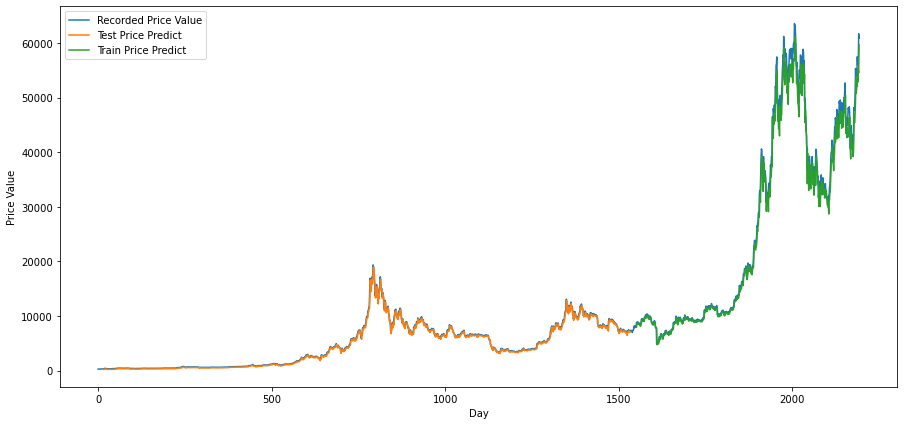

In [22]:
plt.figure(figsize=(15,7))
plt.plot(min_max_scaler.inverse_transform(ds))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["Recorded Price Value", "Test Price Predict", "Train Price Predict" ], loc=2)
plt.ylabel('Price Value')
plt.xlabel('Day')
plt.show()

### R2 and Variance Score

In [23]:
from sklearn.metrics import r2_score
print("R squared value on Train data:", r2_score(trainY,trainPredict))
print("R squared value on Test data:", r2_score(testY,testPredict))

R squared value on Train data: 0.9921000118121078
R squared value on Test data: 0.9883110183360189


In [24]:
from sklearn.metrics import explained_variance_score
print("Variance value on Train data:", explained_variance_score(trainY,trainPredict))
print("Variance value on Test data:", explained_variance_score(testY,testPredict))

Variance value on Train data: 0.9938876176891959
Variance value on Test data: 0.9918812082524059


### Predicting for next n days and Visualization

In [25]:
x_input = test[len(test)-look_back:].reshape(1,-1)

In [26]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [27]:
from numpy import array

lst_output=[]
i=0
n=15   # next number of days for which we are predicting
while(i<n):
    x_input.shape
    
    if(len(temp_input)>look_back):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, look_back, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, look_back,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.901688814163208], [0.8418591618537903], [0.790083646774292], [0.7452454566955566], [0.7047877907752991], [0.6673325896263123], [0.6324151158332825], [0.5999358892440796], [0.5698633790016174], [0.5421492457389832], [0.5166603326797485], [0.4932488203048706], [0.471719890832901], [0.4518871605396271], [0.4335372745990753]]


In [28]:
day_new=np.arange(1, look_back+1)
day_pred=np.arange(look_back+1, look_back+n+1)

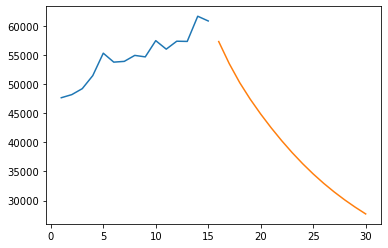

In [29]:
plt.plot(day_new, min_max_scaler.inverse_transform(ds[len(ds)-look_back:]))
plt.plot(day_pred, min_max_scaler.inverse_transform(lst_output))

* Blue curve shows the data for last 15 days of the given data and orange curve show the predicted data for next 15 days based on the blue curve data

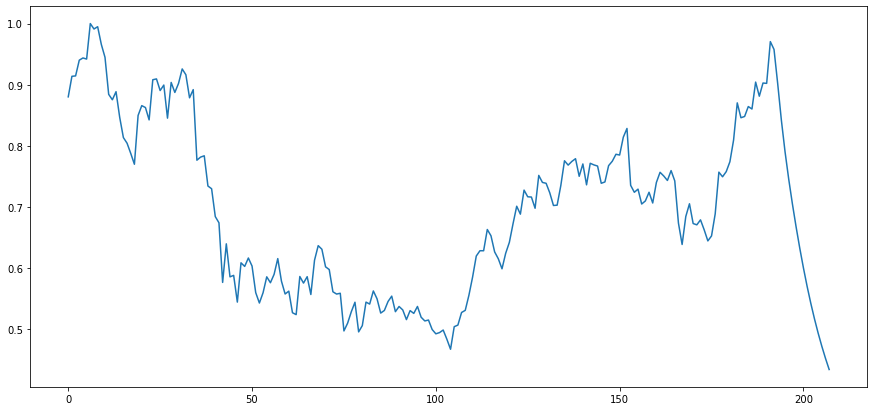

In [30]:
plt.figure(figsize=(15,7))
df0=ds.tolist()
df0.extend(lst_output)
plt.plot(df0[2000:])

* Predicted data of the prevous step is appended to the original data (here shown from day 2000 onwards)

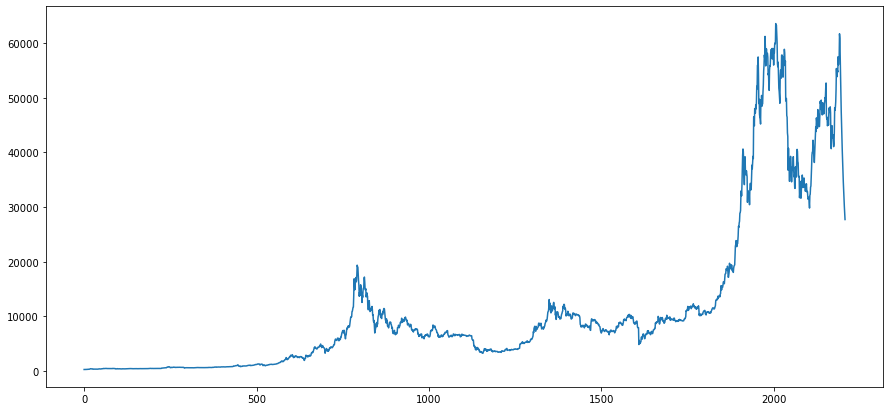

In [31]:
plt.figure(figsize=(15,7))
df0=min_max_scaler.inverse_transform(df0).tolist()
plt.plot(df0)

* Predicted data appended to the original data, complete data shown here

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")